# Studying FEL UQ - Studying Interpolation on Time-ordered data

### In this notebook, the following is done: 
A surrogate model of FEL pulse energy at the SLAC LCLS is trained on archiver (historical) data. The models trained in this notebook are used to understand how a model can be trained on a subset of the data, then used to predict on the next subset of data (which are time-ordered).

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf
import pickle

### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]


import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}
mpl.rc('font', **font)


import QuantRegUtils as qru

#### Load Data

In [2]:
PATH = "../datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

#### Take a look at the input variables

In [3]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = False
## View the names and indicies of each variable
if view:
    for i, v in enumerate(variable_names):
        print(i, v)

#### Data manipulations

The following cell converts the dataframe to numpy arrays and applies the following cuts to the data: 

1) Removing extraneous data: no output values should be less than 0 (units) or greater than 5 (units).


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data:
Input values: (281600, 76)
Output values: (281600,)


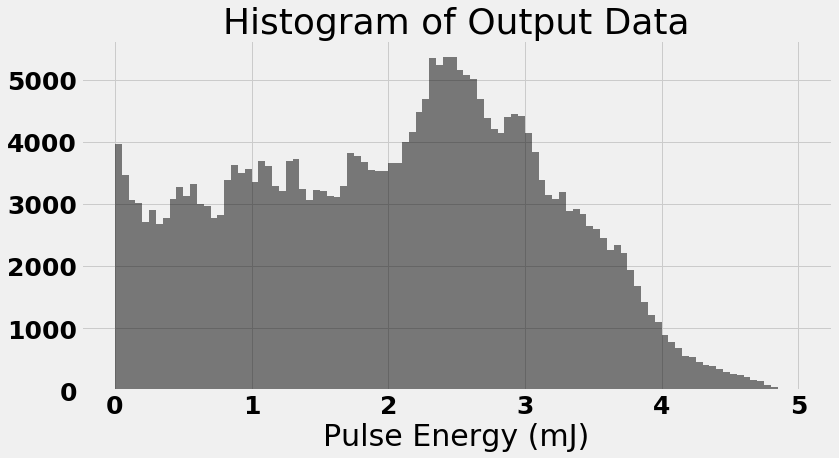

In [4]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]


print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))

## 
n = 281600

input_data = input_data[:n, :]
output_data = output_data[:n]

print("Final shape of data, after cutting out extraneous data:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

plt.figure(figsize = (12,6))
plt.title("Histogram of Output Data")
plt.xlabel("Pulse Energy (mJ)")
plt.hist(output_data, 100, facecolor = colors[0], alpha = 0.5)
plt.show()

#### Scaling information will be needed later, should be saved and set up for use in training and model eval.

In [5]:
PATH = "../models/Interp/"
MODEL_NAME = ""
loading = False
if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME + "x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME + "y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME + "y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, scd = qru.scaling_and_dict(input_data, output_data)

#### Examine Data

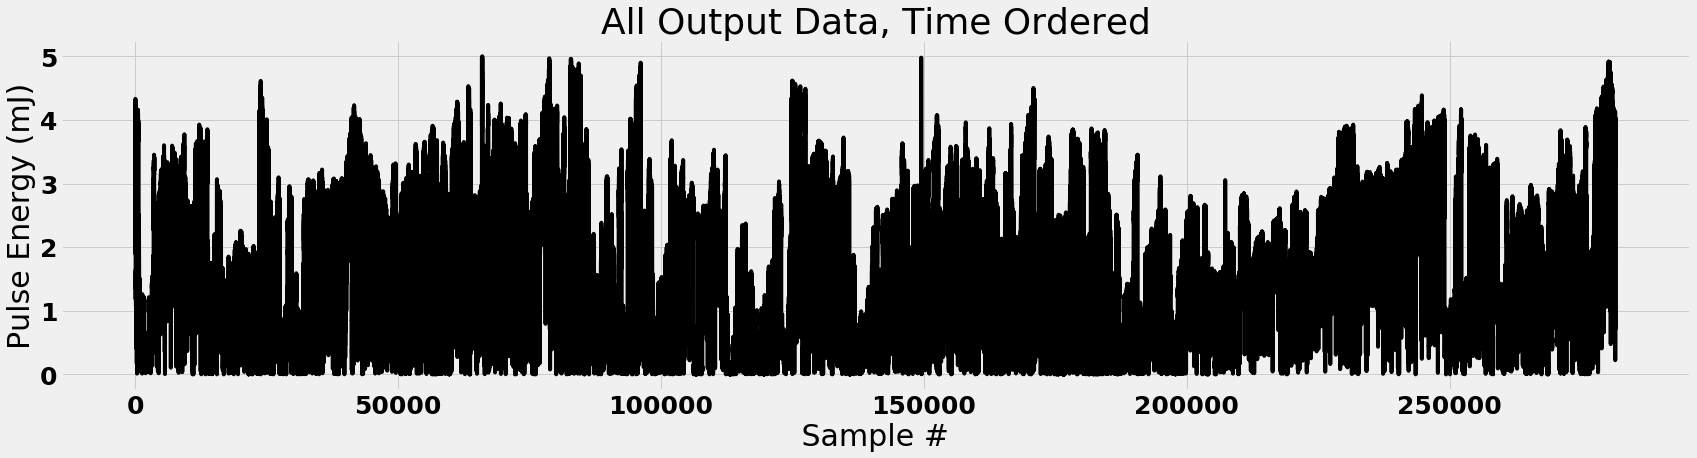

In [13]:
## Take a look at all of the output data
plt.figure(figsize= (26,6))
plt.plot(output_data, color = colors[0])
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel(" Sample # ")
plt.title("All Output Data, Time Ordered")
plt.show()

## Selecting the data of interest!

Data section criteria:
First, a portion of chronological data in which the photon energy measurements are fairly stable throughout the segment was chosen. By observing the performance on this portion of the data, the ability for the model to predict on stable operating parameters can be observed. Another portion in which the measurement value changes significantly (more than 50\%) was also chosen. Similarly, the ability for the model to predict different operational energies can be observed in regions where the measured values change drastically.

In [8]:
n = np.shape(input_data)[0]

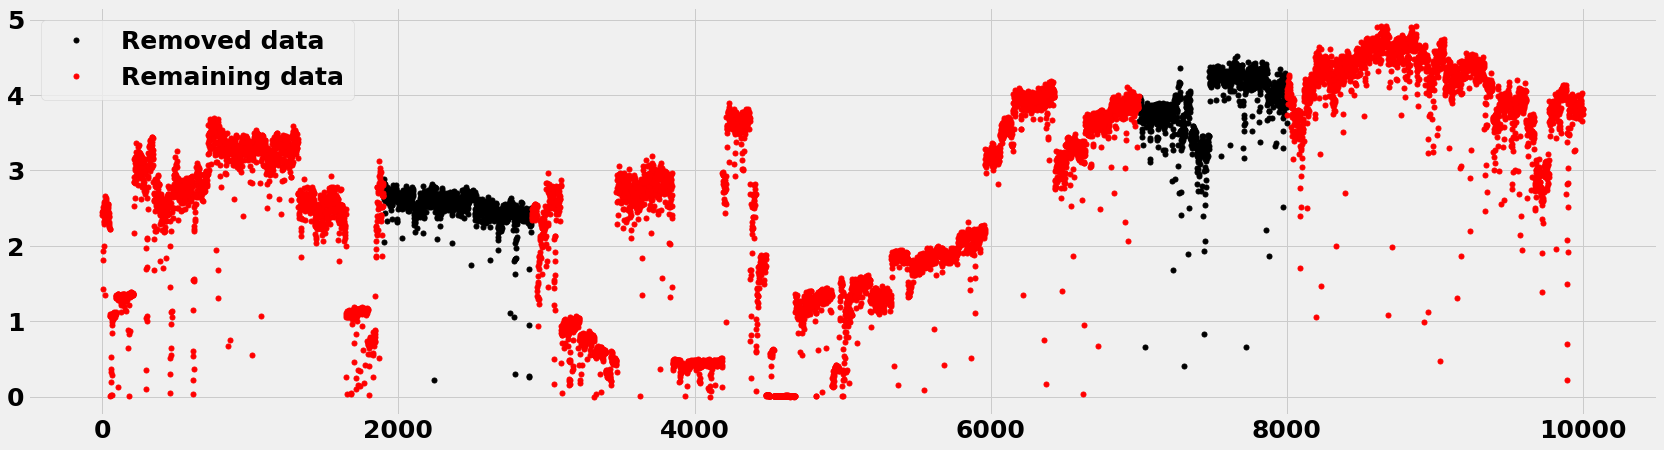

In [12]:
## the following is some "bookkeeping" of data removed, and data used in training.

input_cut = input_data[n-10000:]
output_cut = output_data[n-10000:]
allinds = np.arange(0,10000)

## Indices that will be removed
a = 1900
b = 2900

c = 7000
d = 8000

inds_removed = np.concatenate( (np.arange(a,b), np.arange(c,d)))

plt.figure(figsize= (26,7))

plt.plot(inds_removed, output_cut[inds_removed], '.k', markersize = 10, label = "Removed data")

## Remaining training data
input_rem = np.delete(input_cut, inds_removed, axis = 0)

output_rem = np.delete(output_cut, inds_removed)

remaining = np.delete(allinds, inds_removed)

plt.plot(remaining, output_rem, '.r', markersize = 10, label = "Remaining data")
plt.legend()
plt.show()

Ready to train, and use the "removed data" as the test set!

In [21]:
training_models = False
PATH = "../models/Interp/"
MODEL_NAME = ""
if training_models:

    X_train, X_test, Y_train, Y_test = train_test_split(input_rem, output_rem, test_size = 0.2, random_state = 42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

    input_dict = {}
    input_dict["train"] = X_train
    input_dict["val"] = X_val
    input_dict["test"] = input_cut

    output_dict = {}
    output_dict["train"] = Y_train
    output_dict["val"] = Y_val
    output_dict["test"] = output_cut

    with open(PATH + "inputs.pkl", 'wb') as f:
        pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(PATH + "outputs.pkl", 'wb') as f:
        pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    #### Set up some parameters
    epochs = 5000
    batch_size = 4096

    median = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "median_pred_", QUANTILE = 0.5)
    median.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    upper = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "upper_pred_", QUANTILE = 0.975)
    upper.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    lower = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "lower_pred_", QUANTILE = 0.025)
    lower.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size, saving = False)
    
    print("Completed")
else:

    PATH = "../models/Interp/"
    MODEL_NAME = ""
    NN = PATH + MODEL_NAME + "median_pred_Model_Weights.h5"
    LB = PATH + MODEL_NAME + "lower_pred_Model_Weights.h5"
    UB = PATH + MODEL_NAME + "upper_pred_Model_Weights.h5"

#     with open(PATH + "Interp/inputs.pkl", 'rb') as f:
#         input_dict = pickle.load(f, encoding="utf-8")

#     with open(PATH + "Interp/outputs.pkl", 'rb') as f:
#         output_dict = pickle.load(f)

    median = qru.Model(PATH = PATH, NAME = NN, scaling_dict = scd)   
    median.load()

    upper = qru.Model(PATH = PATH, NAME = UB, scaling_dict = scd)   
    upper.load()

    lower = qru.Model(PATH = PATH, NAME = LB, scaling_dict = scd)   
    lower.load()
    print("All models loaded")
    


    
    

All models loaded


Let's look at the performance!!

In [22]:
out = output_cut
median_pred = median.evaluate(input_cut)
ub_pred = upper.evaluate(input_cut)
lb_pred = lower.evaluate(input_cut)


Do our 95% confidence intervals actually include 95% of the measurements?

In [23]:
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

mse, mae = qru.calc_mse_and_mae(median_pred[:,0], out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))
print("MSE:", mse)
print("MAE:", mae)

The percent of measured values within the confidence interval is: 85.63%
MSE: 0.11800161918408662
MAE: 0.17412476059445914


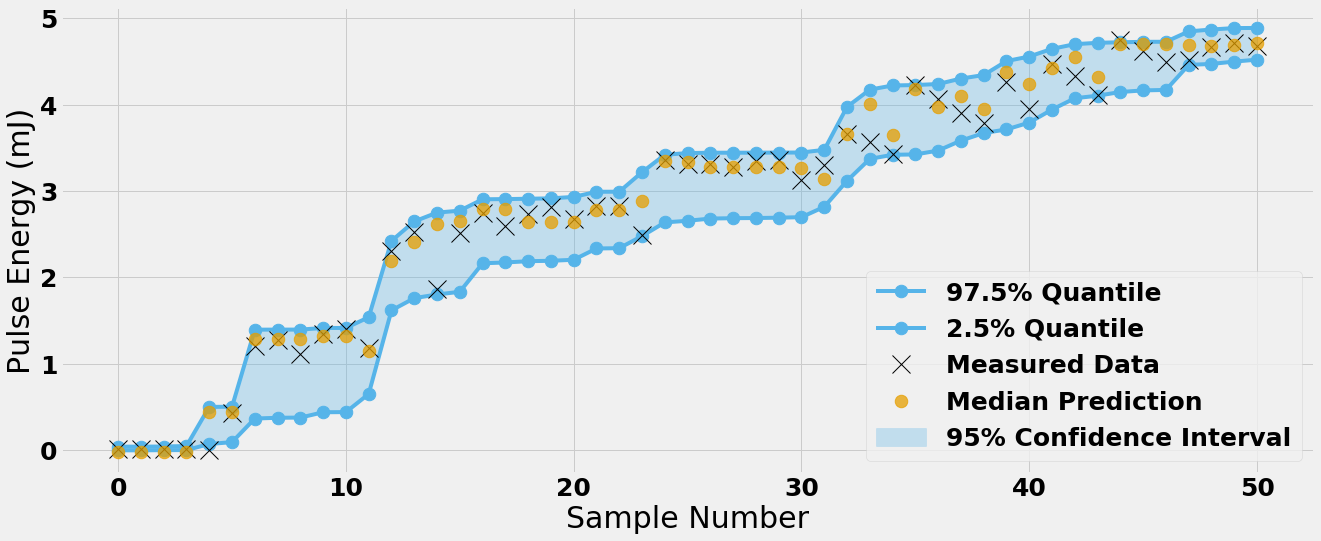

In [24]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

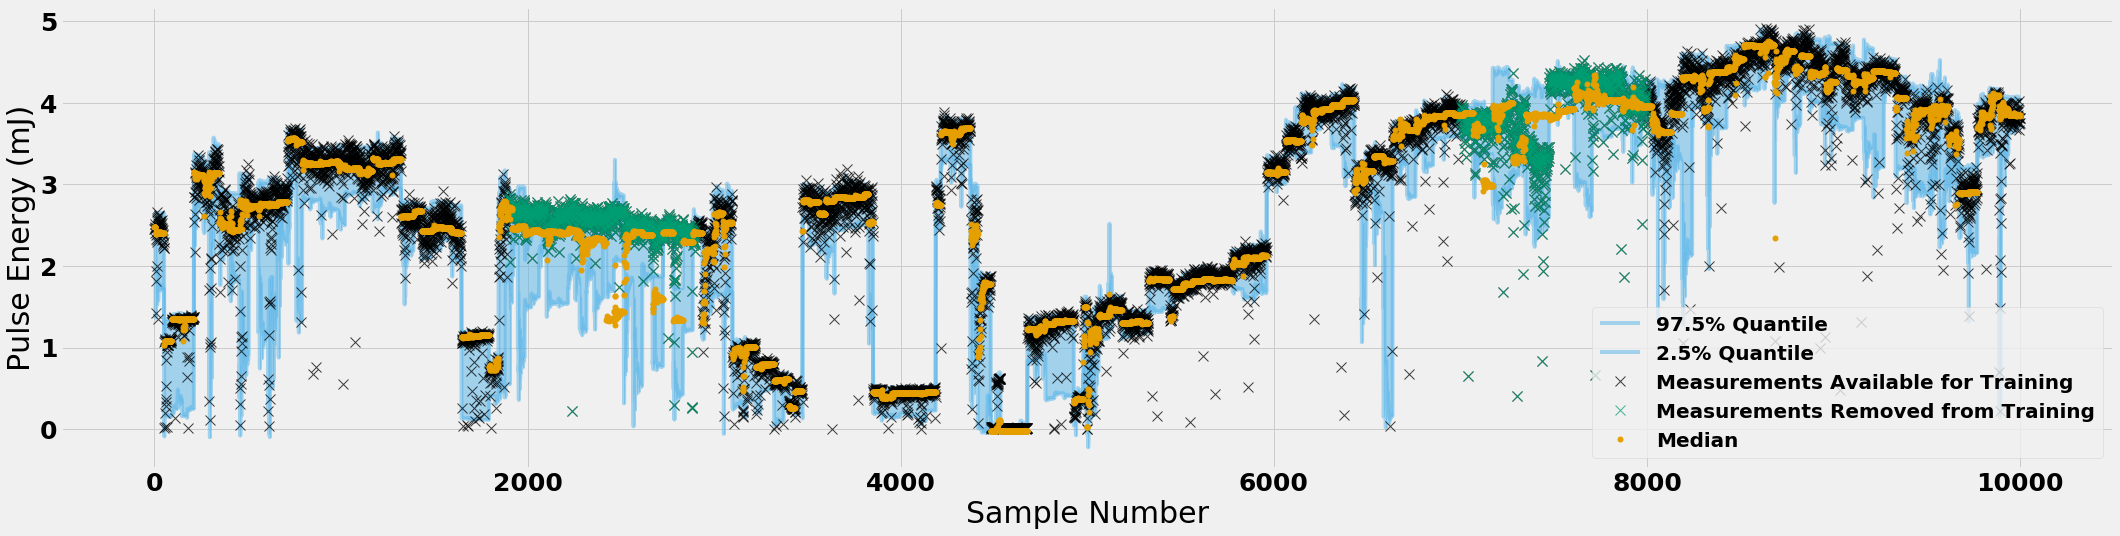

In [25]:
mpl.style.use('seaborn-bright')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)

markersize = 10
plt.figure(figsize = (30, 8))
plt.plot(allinds, ub_pred[:,0], color = colors[2], alpha = 0.5, label = "97.5% Quantile", markersize = markersize)
plt.plot(allinds, lb_pred[:,0], color = colors[2], alpha = 0.5, label = "2.5% Quantile",markersize = markersize)
plt.plot(allinds, out, 'x', color = colors[0], alpha = 0.75 , label = "Measurements Available for Training",markersize = markersize)
plt.plot(inds_removed, out[inds_removed], 'x', color = colors[3], alpha = 0.75 , label = "Measurements Removed from Training",markersize = markersize)
plt.plot(allinds, median_pred[:,0], '.', color = colors[1], label = "Median",markersize = markersize)
plt.fill_between(allinds, ub_pred[:,0], lb_pred[:,0], color = colors[2], alpha = 0.5)

plt.legend(fontsize = 20)
plt.xlabel("Sample Number")
plt.ylabel("Pulse Energy (mJ)")
plt.tight_layout()
## Saving:
# plt.savefig("interpolation_1.png", transparent = True)
plt.show()

In [26]:
out = output_cut[inds_removed]
median_pred = median.evaluate(input_cut[inds_removed])
ub_pred = upper.evaluate(input_cut[inds_removed])
lb_pred = lower.evaluate(input_cut[inds_removed])
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))
mse, mae = qru.calc_mse_and_mae(median_pred[:,0], out)
print("MSE:", mse)
print("MSE:", mae)

The percent of measured values within the confidence interval is: 53.35%
MSE: 0.24165262117497116
MSE: 0.3373187331155357
